In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy

In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


In [3]:
gals2 = pklload("./database/01_nh_ghmatch.pickle")
LG = pklload(f"./database/11_LocalGroup.pickle")
del LG[11]
del LG[136]
del LG[937]
del LG[168]
del LG[212]
subhalo_pairs = pklload(f"./database/06_nh_subhalo_pairs.pickle")
scores = pklload(f"./database/08_nh_scores.pickle")
dm_scores = pklload(f"./database/08_nh_dm_scores.pickle")
vac = pklload("./database/09_value_added.pickle")
MWAs = pklload("./database/03_MWA1s.pickle")

In [50]:
LG[1].keys()

dict_keys(['BGG', 'neighbor', 'sats', 'subs', 'real'])

In [4]:
key = 10

BGG = LG[key]['BGG']
neighbor = LG[key]['neighbor']
sats = LG[key]['sats']
subs = LG[key]['subs']
real = LG[key]['real']

# Real Satellites

In [30]:
ingals = cut_sphere(gals, BGG['x'], BGG['y'], BGG['z'], 1.5*BGG['r200_code'], both_sphere=True)
ingals = ingals[ingals['id'] != BGG['id']]
myscore = deepcopy( scores['take'][key] )
if(BGG['id'] in myscore.keys()):
    del myscore[BGG['id']]
if(len(neighbor)>0):
    for neigh in neighbor:
        assert neigh['id'] in MWAs['id']
        neighG = MWAs[MWAs['id'] == neigh['id']][0]
        tmp = cut_sphere(gals, neighG['x'], neighG['y'], neighG['z'], 1.5*neighG['r200_code'], both_sphere=True)
        tmp = tmp[tmp['id'] != BGG['id']]
        tmp = tmp[~isin(tmp['id'], ingals['id'])]
        ingals = np.hstack((ingals, tmp))

        tmp = scores['take'][neigh['id']]
        for ikey in tmp.keys():
            if(ikey == BGG['id']): continue
            if(not ikey in myscore.keys()):
                myscore[ikey] = tmp[ikey]

goodind = np.zeros(len(ingals), dtype=bool)
for i, ingal in enumerate(ingals):
    try: # For satellite
        assert ingal['id'] in myscore.keys()
        goodind[i] = np.median(myscore[ingal['id']]%1) > 0.15
    except: # For neighbor BGG
        goodind[i] = True
leng = np.sum(goodind)
goodsats = ingals[goodind]

satdtype = sats.dtype
newsats = np.empty(leng, dtype=satdtype)
for i, goodsat in enumerate(goodsats):
    tvac = vac[vac['Sat'] == goodsat['id']][0]
    for iname in satdtype.names:
        if(iname in gals.dtype.names):
            newsats[i][iname] = goodsat[iname]
        elif(iname in gals2.dtype.names):
            newsats[i][iname] = gals2[goodsat['id']-1][iname]
        elif(iname in vac.dtype.names):
            newsats[i][iname] = tvac[iname]
print(sats.shape, newsats.shape)

(12,) (14,)


# Real Subhalos

In [29]:
print(BGG['halo_id'])
inhals = cut_sphere(hals, BGG['x'], BGG['y'], BGG['z'], 1.5*BGG['r200_code'], both_sphere=True)
inhals = inhals[inhals['id'] != BGG['halo_id']]
myscore = deepcopy( dm_scores['take'][key] )
if(BGG['halo_id'] in myscore.keys()):
    del myscore[BGG['halo_id']]
if(len(neighbor)>0):
    for neigh in neighbor:
        assert neigh['id'] in MWAs['id']
        neighG = MWAs[MWAs['id'] == neigh['id']][0]
        tmp = cut_sphere(hals, neighG['x'], neighG['y'], neighG['z'], 1.5*neighG['r200_code'], both_sphere=True)
        tmp = tmp[tmp['id'] != BGG['halo_id']]
        tmp = tmp[~isin(tmp['id'], inhals['id'])]
        inhals = np.hstack((inhals, tmp))

        tmp = dm_scores['take'][neigh['id']]
        for ikey in tmp.keys():
            if(ikey == BGG['halo_id']): continue
            if(not ikey in myscore.keys()):
                myscore[ikey] = tmp[ikey]

goodind = np.zeros(len(inhals), dtype=bool)
goodind[:] = False
for i, inhal in enumerate(inhals):
    try: # For subhalo
        assert inhal['id'] in myscore.keys()
        goodind[i] = np.median(myscore[inhal['id']]%1) > 0.25
    except: # For neighbor BGG
        print(f"\t! {inhal['id']} is not in myscore.keys()")
        goodind[i] = True
leng = np.sum(goodind)
goodsubs = inhals[goodind]
newsubs = goodsubs
print(subs.shape, newsubs.shape)

5461
(91,) (90,)


# Matching

(24285, 104, 'pair')
(24299, 347, 'pair')
(24308, 740, 'pair')
(24368, 1806, 'pair')
(24361, 1805, 'pair')
(24374, 716, 'pair')
(24321, 380, 'pair')
(24272, 626, 'pair')
(24389, 2718, 'pair')
(24345, 678, 'pair')
(24343, 605, 'pair')
(0, 1809, 'orphan')
(24336, 355, 'pair')
(24366, 902, 'pair')
13/14 are matched
[( 5712,   -1, 'dink') ( 5825,   -1, 'dink') (14322,   -1, 'dink')
 (14525,   -1, 'dink') (24167,   -1, 'dink') (24176,   -1, 'dink')
 (24183,   -1, 'dink') (24188,   -1, 'dink') (24193,   -1, 'dink')
 (24204,   -1, 'dink') (24223,   -1, 'dink') (24226,   -1, 'dink')
 (24228,   -1, 'dink') (24236,   -1, 'dink') (24239,   -1, 'dink')
 (24247,   -1, 'dink') (24248,   -1, 'dink') (24250,   -1, 'dink')
 (24251,   -1, 'dink') (24253,   -1, 'dink') (24256,   -1, 'dink')
 (24257,   -1, 'dink') (24260,   -1, 'dink') (24265,   -1, 'dink')
 (24267,   -1, 'dink') (24268,   -1, 'dink') (24269,   -1, 'dink')
 (24272,  626, 'pair') (24275,   -1, 'dink') (24276,   -1, 'dink')
 (24285,  104, '

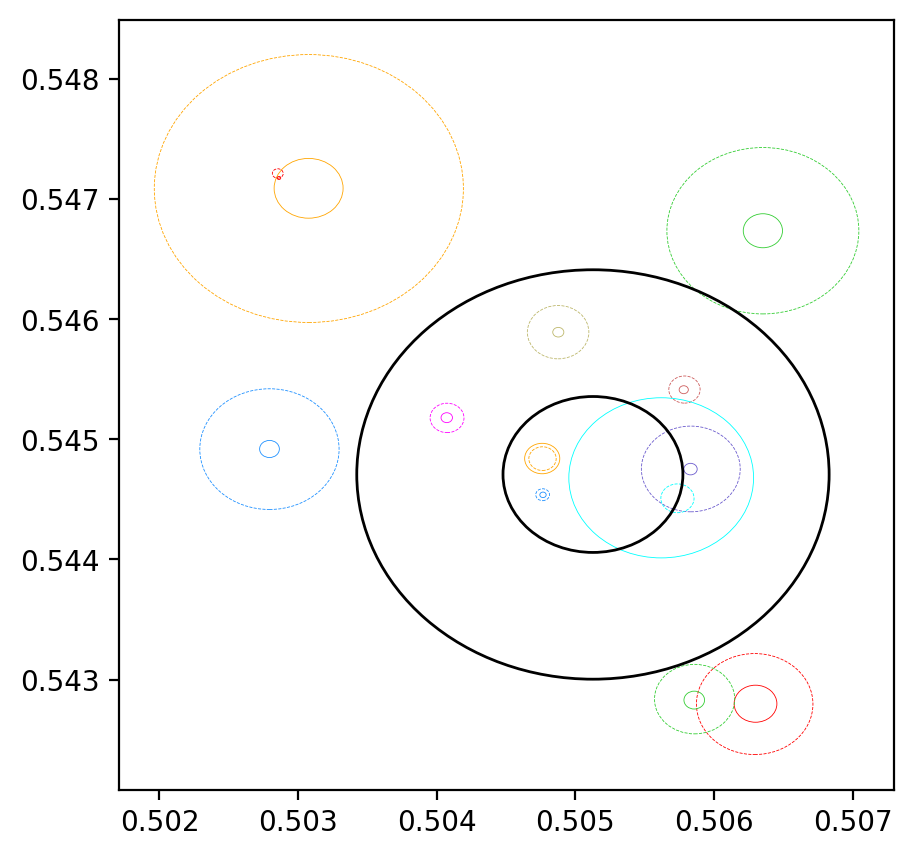

In [52]:
# Initialize
newreals = np.empty(len(newsats)+len(newsubs), dtype=real.dtype)
newreals['hid'] = -1
newreals['gid'] = -1
for i, newsub in enumerate(newsubs):
    newreals[i]['hid'] = newsub['id']
    newreals[i]['state'] = 'dink'





# 1. Both inside center
count = 0
argsort = np.argsort(-newsats['m'])
inewsats = newsats[argsort]
for i, newsat in enumerate(inewsats):
    if(newsat['id'] in newreals['gid']): continue
    already = newreals['hid'][newreals['gid']>0]
    inewsubs = newsubs[~isin(newsubs['id'], already)]
    insides = point_in_sphere(inewsubs, newsat, rname='r')
    if(np.sum(insides)==0): insides = sphere_in_sphere(newsat, inewsubs, r2='rvir')
    if(np.sum(insides)==0): insides = sphere_touch_sphere(newsat, inewsubs, r2='rvir')
    if(np.sum(insides)==0): insides = sphere_in_sphere(newsat, inewsubs, r2='r')
    if(np.sum(insides)==0): insides = sphere_touch_sphere(newsat, inewsubs, r2='r')
    if(np.sum(insides)==0):
        # orphan
        where = np.where(newreals['hid'] == -1)[0][0]
        newreals[where]['hid'] = 0
        newreals[where]['gid'] = newsat['id']
        newreals[where]['state'] = 'orphan'
    
    cands = inewsubs[insides]
    if(len(cands)==0):
        pass
    elif(len(cands)==1):
        cand = cands[0]
        where = np.where(newreals['hid'] == cand['id'])[0][0]
        newreals[where]['gid'] = newsat['id']; count+=1
        newreals[where]['state'] = 'pair'
    else:
        dists = distance(newsat, cands)
        argmin = np.argmin(dists)
        cand = cands[argmin]
        where = np.where(newreals['hid'] == cand['id'])[0][0]
        newreals[where]['gid'] = newsat['id']; count+=1
        newreals[where]['state'] = 'pair'
    print(newreals[where])
print(f"{count}/{len(inewsats)} are matched")

mask = (newreals['hid']>0)|(newreals['gid']>0)
newreals = newreals[mask]




fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=200)
ax.scatter(inewsats['x'], inewsats['y'], color='r', s=0)
init_colors()
pairs = newreals[newreals['state']=='pair']
for pair in pairs:
    sat = newsats[newsats['id']==pair['gid']][0]
    sub = newsubs[newsubs['id']==pair['hid']][0]
    color = get_color()
    cir = plt.Circle((sat['x'], sat['y']), sat['r'], fill=False, ls='-', lw=0.3, color=color)
    ax.add_patch(cir)
    cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], fill=False, ls='--', lw=0.3, color=color)
    ax.add_patch(cir)

cir = plt.Circle((BGG['x'], BGG['y']), BGG['r'], color='k', fill=False)
ax.add_patch(cir)
cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='k', fill=False)
ax.add_patch(cir)

print(newreals)

In [ ]:



# # 1. Both inside center
# count = 0
# for i, newsat in enumerate(newsats):
#     if(newsat['id'] in newreals['gid']): continue
#     insides = point_in_sphere(newsubs, newsat, rname='r')
#     cands = newsubs[insides]
#     if(len(cands)==0):
#         pass
#     elif(len(cands)==1):
#         cand = cands[0]
#         inside = point_in_sphere(newsat, cand, rname='r')
#         if(inside):
#             where = np.where(newreals['hid'] == cand['id'])[0][0]
#             newreals[where]['gid'] = newsat['id']; count+=1
#     else:
#         insides = point_in_sphere(newsat, cands, rname='r')
#         cands = cands[insides]
#         if(len(cands)==0):
#             pass
#         elif(len(cands)==1):
#             cand = cands[0]
#             inside = point_in_sphere(newsat, cand, rname='r')
#             if(inside):
#                 where = np.where(newreals['hid'] == cand['id'])[0][0]
#                 newreals[where]['gid'] = newsat['id']; count+=1
#         else:
#             print(newsat['id'], len(cands))
#             for cand in cands:
#                 inside = point_in_sphere(newsat, cand, rname='r')
#                 if(inside):
#                     where = np.where(newreals['hid'] == cand['id'])[0][0]
#                     newreals[where]['gid'] = newsat['id']; count+=1
#                 print(newsat['id'], cand['id'], inside)
# print(f"{count}/{len(newsats)} are matched")

# # 2. Gal in Hal
# for i, newsat in enumerate(newsats):
#     if(newsat['id'] in newreals['gid']): continue
#     insides = point_in_sphere(newsat, newsubs, rname='r')
#     cands = newsubs[insides]
#     if(len(cands)==0):
#         pass
#     elif(len(cands)==1):
#         cand = cands[0]
#         where = np.where(newreals['hid'] == cand['id'])[0][0]
#         newreals[where]['gid'] = newsat['id']
#     else:
#         dists = distance(newsat, cands)
#         insides = (dists+newsat['r']) < cands['r']
#         cands = cands[insides]
#         if(len(cands)==0):
#             pass
#         elif(len(cands)==1):
#             cand = cands[0]
#             where = np.where(newreals['hid'] == cand['id'])[0][0]
#             newreals[where]['gid'] = newsat['id']
#         else:
#             print(newsat['id'], len(cands))
#             # for cand in cands:
#             #     inside = point_in_sphere(newsat, cand, rname='r')
#             #     if(inside):
#             #         where = np.where(newreals['hid'] == cand['id'])[0][0]
#             #         newreals[where]['gid'] = newsat['id']
#             #     print(newsat['id'], cand['id'], inside)

In [8]:
np.median(scores['take'][key][ingal['id']]%1)

0.002551020408191107

In [9]:
cut_sphere(gals, BGG['x'], BGG['y'], BGG['z'], 1.5*BGG['r200_code'], both_sphere=True).shape

(97,)

In [10]:
len( scores['take'][1].keys() )

96

In [11]:
sats.shape

(10,)